# Most Effective Hair Removal
## Some things still need to be updated since it is extremely inefficient, but this is the base version of the code.
    1. The images need to be resized to the same size. They are currently all being scaled down by 50%. Please see the first block of code. There is a resizeImage function. We need to make sure that when the images are resized that the lesion is still included. We also want to preserve the aspect ratio as much as possible. (Jennifer) 
    2. We need to adjust the amount in which we are blurring the edges (Jennifer)
    3. We need to make the get coordinates code much more efficient
    4. We need to pick a type of contrast to stick with
    5. We need to update the averaging algorithm so that it removes the big clumps of hair

In [7]:
import cv2
import matplotlib.pyplot as plt
from matplotlib.colors import hsv_to_rgb
import numpy as np
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
from matplotlib import colors
import colorsys

imageNames = [
    "5436e3c6bae478396759f233.jpg",
    "5aaf1253116597691362835b.jpg",
    "5aaf12ba116597691362b671.jpg",
    "5aaf13841165976913631d42.jpg",
    "5aaf1320116597691362ea91.jpg",
    "5592cfca9fc3c131551458e7.jpg",
    "5436e3b8bae478396759f18d.jpg"
]

def resizeImage(src, scale_percent):

    #calculate the 50 percent of original dimensions
    width = int(src.shape[1] * scale_percent / 100)
    height = int(src.shape[0] * scale_percent / 100)

    # dsize
    dsize = (width, height)

    # resize image
    return cv2.resize(src, dsize)


def printImageSize(src, new_width, new_height):
        
    #checking OG image size
    w= (src.shape[1])
    h = (src.shape [0])

    p_size = (w, h)
    print (p_size)
    
    #find center to crop around lesion 
    w_center, h_center = img.shape[1] / 2, img.shape[0] / 2
    w_scaled, h_scaled = img.shape[1] * .10, img.shape[0] * .10
    new_img = src[0:int(w_scaled), 0:int(h_scaled)]
    
    #adjust new dimensions (pixels)
    newSize = (new_width, new_height)
    
    return cv2.resize(src, newSize)



def readAndConvert(image):
    im = cv2.imread(image)
    return resizeImage(cv2.cvtColor(im, cv2.COLOR_BGR2RGB), 50)

images = [readAndConvert(image)for image in imageNames]

colorSpaceCount = 6

RGB = "RGB"
HSV = "HSV"
LUV = "LUV"
LUV_INVERTED = "LUV_INVERTED"
XYZ = "XYZ"
# "YUV": cv2.cvtColor(im_luv, cv2.COLOR_RGB2YUV),
HSL = "HSL"
# GRAY = "GRAY"

def getImageSpaces(im_RGB):
    return {
        RGB: im_RGB,
        HSV: cv2.cvtColor(im_RGB, cv2.COLOR_RGB2HSV),
        LUV: cv2.cvtColor(im_RGB, cv2.COLOR_RGB2LUV),
        LUV_INVERTED: cv2.bitwise_not(cv2.cvtColor(im_RGB, cv2.COLOR_RGB2LUV)),
        XYZ: cv2.cvtColor(im_RGB, cv2.COLOR_RGB2XYZ),
        # "YUV": cv2.cvtColor(im_luv, cv2.COLOR_RGB2YUV),
        HSL: cv2.cvtColor(im_RGB, cv2.COLOR_RGB2HLS)
#         GRAY: cv2.cvtColor(im_RGB, cv2.COLOR_RGB2GRAY)

    }

error: OpenCV(3.4.2) c:\miniconda3\conda-bld\opencv-suite_1534379934306\work\modules\imgproc\src\color.hpp:253: error: (-215:Assertion failed) VScn::contains(scn) && VDcn::contains(dcn) && VDepth::contains(depth) in function 'cv::CvtHelper<struct cv::Set<3,4,-1>,struct cv::Set<3,4,-1>,struct cv::Set<0,2,5>,2>::CvtHelper'


In [8]:
def greenHighlights2(imageIndex, edges):
    indices = np.where(edges != [0])
    coordinates = zip(indices[0], indices[1])
    
    img2 =  readAndConvert(imageNames[imageIndex])

    for c in coordinates:
        img2[c[0], c[1]] = (0,0,0)
    
    return img2


In [9]:
def getCoordinates(index, radius, w, h):
#     startingCorner = [index[0] - radius, index[1] - radius]
    result = []
    for i in range(index[0] - radius, index[0] + radius + 1):
        if i >= h:
            break
        if i >= 0:
            for j in range(index[1] - radius, index[1] + radius + 1):
                if j >= w:
                    break
                if j >= 0:
                    result.append([i, j])

            
#     print(result)
    return result

In [8]:
from statistics import mean 

def blurHairs2(imageIndex, edges, imageWithBlack):
    indices = np.where(edges != [0])
    coordinates = zip(indices[0], indices[1])
    
    img2 =  readAndConvert(imageNames[imageIndex])        
    h, w, c = img2.shape
    print(h, w, c)
    for c in coordinates:
        x = c[0]
        y = c[1]
        r = 0
        g = 0
        b = 0
        count = 0
        exceptions = 0
        tempCoordinates = getCoordinates([x,y], 10, w, h)#[[x, y+1], [x, y-1], [x+1, y], [x+1, y+1], [x+1, y-1], [x-1, y], [x-1, y+1], [x-1, y-1]]
        for c2 in tempCoordinates:
            x2 = c2[0]
            y2 = c2[1]
            try:
                if imageWithBlack[x2, y2][0] != 0 and imageWithBlack[x2, y2][1] != 0 and imageWithBlack[x2, y2][2] != 0:
                    r = r + img2[x2, y2][0]
                    g = g + img2[x2, y2][1]
                    b = b + img2[x2, y2][2]
                    count = count + 1
            except:
                print()
#             print(count)
            if count > 0:
#                 print([r/count, g/count, b/count])
                img2[x,y] = [r/count, g/count, b/count]
#                 print(img2[x,y])
    return img2

In [10]:
'''
Simple and fast image transforms to mimic:
 - brightness
 - contrast
 - erosion 
 - dilation
'''
def showContrastWithBluredEdgeDetection2(imageNameIndex):
    from pylab import array, plot, show, axis, arange, figure, uint8 

    row = 3
    col = 6

    fig2, axs = plt.subplots(row,col,  figsize=(25,7))
    fig2.suptitle('Contrast')


    # Image data
    image = resizeImage(cv2.imread(imageNames[imageNameIndex],0), 50) # load as 1-channel 8bit grayscale
    

#     # Checking the dimensions of new image 
#     dimensions = printImageSize(cv2.imread(imageNames[imageNameIndex],0), 300, 300) 
#     width_new = dimensions.shape[1]
#     height_new = dimensions.shape[0]
#     new_dimensions = width_new, height_new
#     print (new_dimensions)
# #     plt.imshow(dimensions)

    
    
    
    axs[0, 0].set_title('Image')
    axs[0, 0].imshow(image)
    maxIntensity = 255.0 # depends on dtype of image data
    x = arange(maxIntensity) 
    edges = cv2.Canny(image,100,200)
    axs[0, 1].set_title('edges')
    axs[0, 1].imshow(edges)
    
    axs[0, 2].set_title('identificaiton without blur')
    axs[0, 2].imshow(greenHighlights2(imageNameIndex, edges))
    
    edges2 =cv2.bilateralFilter(edges,10,350,9)
    axs[0, 3].set_title('blurred edges')
    axs[0, 3].imshow(edges2)
    
    axs[0, 4].set_title('identificaiton with blur')
    blackHighlights = greenHighlights2(imageNameIndex, edges2)
    axs[0, 4].imshow(blackHighlights)
    
    axs[0, 5].set_title('removed hairs')
    axs[0, 5].imshow(blurHairs2(imageNameIndex, edges2, blackHighlights))
    
    

    # Parameters for manipulating image data
    phi = 1
    theta = 1

    # Increase intensity such that
    # dark pixels become much brighter, 
    # bright pixels become slightly bright
    newImage0 = (maxIntensity/phi)*(image/(maxIntensity/theta))**0.5
    newImage0 = array(newImage0,dtype=uint8)

    axs[1, 0].set_title('dark pixels => much brighter : bright pixels => slightly bright')
    axs[1, 0].imshow(newImage0)
    edges = cv2.Canny(newImage0,100,200)
    axs[1, 1].set_title('edges')
    axs[1, 1].imshow(edges)
    
    axs[1, 2].set_title('identificaiton without blur')
    axs[1, 2].imshow(greenHighlights2(imageNameIndex, edges))
    
    edges2 =cv2.bilateralFilter(edges,10,350,9)
    axs[1, 3].set_title('blurred edges')
    axs[1, 3].imshow(edges2)
    
    axs[1, 4].set_title('identificaiton with blur')
    blackHighlights = greenHighlights2(imageNameIndex, edges2)
    axs[1, 4].imshow(blackHighlights)
    
    axs[1, 5].set_title('removed hairs')
    axs[1, 5].imshow(blurHairs2(imageNameIndex, edges2, blackHighlights))

    y = (maxIntensity/phi)*(x/(maxIntensity/theta))**0.5

    # Decrease intensity such that
    # dark pixels become much darker, 
    # bright pixels become slightly dark 
    newImage1 = (maxIntensity/phi)*(image/(maxIntensity/theta))**2
    newImage1 = array(newImage1,dtype=uint8)


    axs[2, 0].set_title('dark pixels => much darker : light pixels => slightly darker')
    axs[2, 0].imshow(newImage1)
    edges = cv2.Canny(newImage1,100,200)
    axs[2, 1].set_title('edges')
    axs[2, 1].imshow(edges)
    
    axs[2, 2].set_title('identificaiton without blur')
    axs[2, 2].imshow(greenHighlights2(imageNameIndex, edges))
    
    edges2 =cv2.bilateralFilter(edges,10,350,9)
    axs[2, 3].set_title('blurred edges')
    axs[2, 3].imshow(edges2)
    
    axs[2, 4].set_title('identificaiton with blur')
    blackHighlights = greenHighlights2(imageNameIndex, edges2)
    axs[2, 4].imshow(blackHighlights)
    
    axs[2, 5].set_title('removed hairs')
    axs[2, 5].imshow(blurHairs2(imageNameIndex, edges2, blackHighlights))

    z = (maxIntensity/phi)*(x/(maxIntensity/theta))**2

    # # Plot the figures
    # figure()
    # plot(x,y,'r-') # Increased brightness
    # plot(x,x,'k:') # Original image
    # plot(x,z, 'b-') # Decreased brightness
    # #axis('off')
    # axis('tight')
    # show()

    # # Close figure window and click on other window 
    # # Then press any keyboard key to close all windows
    # closeWindow = -1
    # while closeWindow<0:
    #     closeWindow = cv2.waitKey(1) 
    # cv2.destroyAllWindows()

AttributeError: 'NoneType' object has no attribute 'shape'

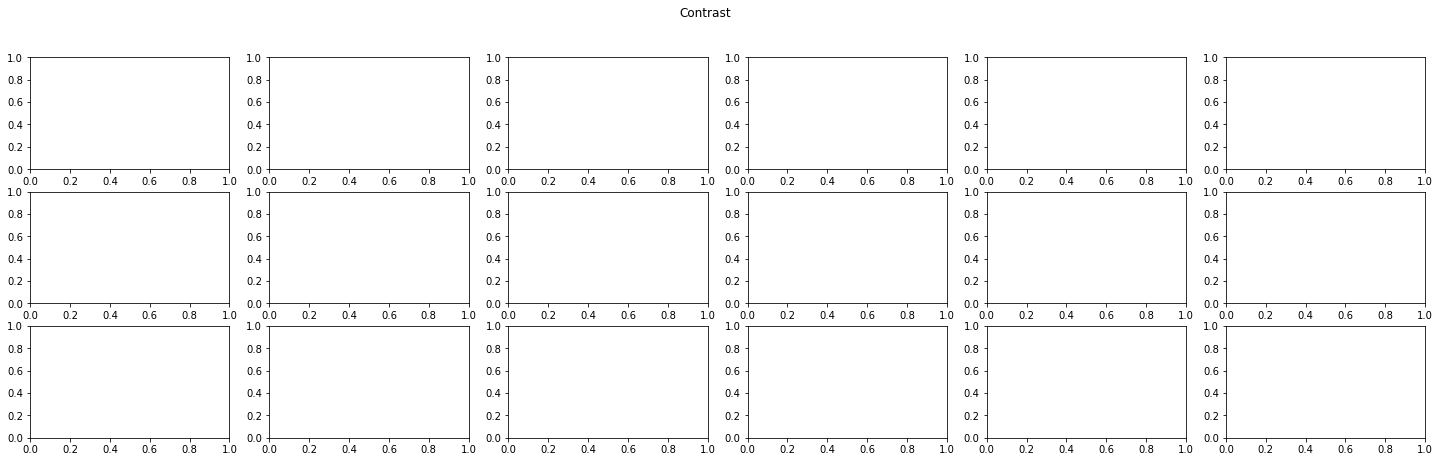

In [11]:
# for i in range(7):
showContrastWithBluredEdgeDetection2(2)

AttributeError: 'NoneType' object has no attribute 'shape'

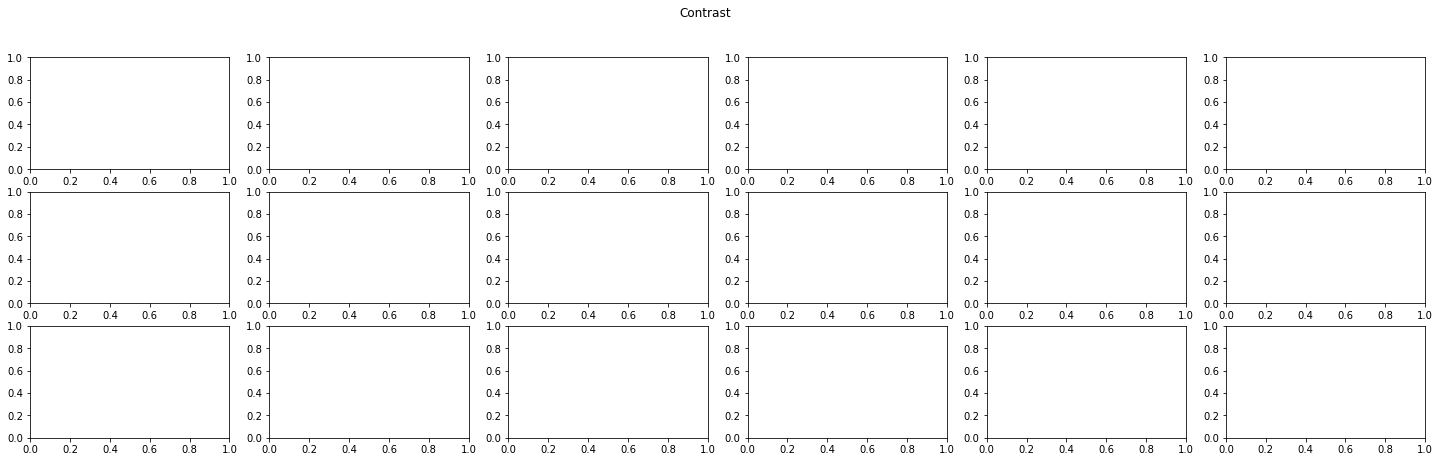

In [12]:
showContrastWithBluredEdgeDetection2(2)

In [ ]:
for i in range(7):
    showContrastWithBluredEdgeDetection2(i)
    print("Image", i)